## L1-based models for Sparse Signals
This present **three L1-based reg. models**( Lasso, ARD, Elas..) on a synthetic signal. Signal is obtained from **sparse and cor. features** that are corrupted with noise.(signal rebuild)

## Generate synthetic dataset
dataset: n_samples < n_features,  So it is a undertermined system. It have infinite solution, so we can't apply an Ordinary Least Squares, Regularization will introduce a penelty term to limit coefficients.

1. make sparse matrix

In [5]:
import numpy as np
rng = np.random.RandomState(42)
n_samples,n_features, n_informative = 50,100,10
time_step=np.linspace(-2,2,n_samples)
freqs = 2*np.pi*np.sort(rng.rand(n_features))/0.01
X=np.zeros((n_samples, n_features))

for i in range(n_features):
    X[:, i]=np.sin(freqs[i]*time_step)

# 
idx = np.arange(n_features)
true_coef = (-1)**idx*np.exp(-idx/10) # 符号交替的，系数逐渐变小
true_coef[n_informative:] =0 # sparsify coef
y=np.dot(X,true_coef)
print(true_coef)


[ 1.         -0.90483742  0.81873075 -0.74081822  0.67032005 -0.60653066
  0.54881164 -0.4965853   0.44932896 -0.40656966  0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0. 

Text(0.5, 1.0, '5-features sin bo')

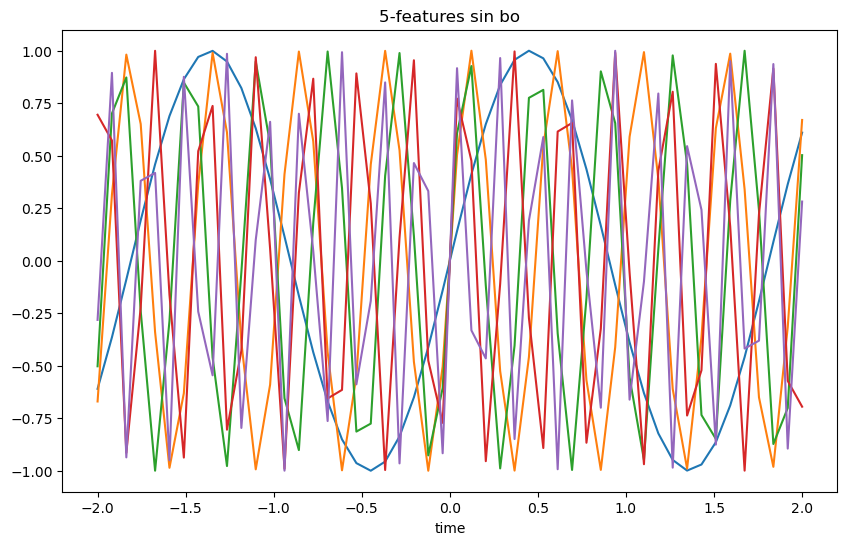

In [6]:
import matplotlib.pyplot as plt
# 可视化前几个特征
plt.figure(figsize=(10, 6))
for i in range(5):  # 只绘制前5个特征
    plt.plot(time_step, X[:, i], label=f'Feature {i+1}, Freq={freqs[i]:.2f}')
plt.xlabel('time')
plt.title('5-features sin bo')

2. introduce some random and gaus. noise. to features and target

In [7]:
for i in range(n_features):
    X[:, i] = np.sin(freqs[i] * time_step + 2*(rng.random_sample() - 0.5))
    X[:, i]+= 0.2*rng.normal(0,1,n_samples)
y +=  0.2*rng.normal(0,1,n_samples)

50行50样本对应50个时间点，X一列即为50个时间下的一特征正弦波值，y为信号

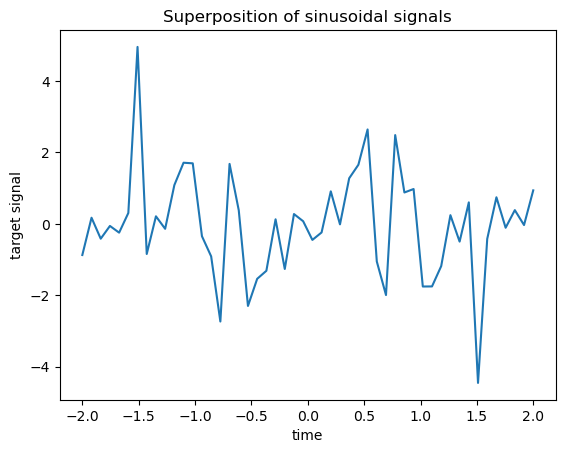

In [8]:
import matplotlib.pyplot as plt
plt.plot(time_step,y)
plt.ylabel("target signal")
plt.xlabel("time")
_ = plt.title("Superposition of sinusoidal signals")

We split the data into train and test sets for simplicity. In practice one should use a <u>TimeSeriesSplit</u> cross-validation to estimate the variance of the test score.   
Here we set shuffle="False" as we **must not use** training data that succeed the testing data when dealing with data that have a **temporal relationship**.

In [9]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =  train_test_split(X, y, test_size=0.5, shuffle=False)

In [10]:
print(X_train.shape)
print(y_train.shape)

(25, 100)
(25,)


In the following, we compute the performance of three l1-based models in terms of the goodness of fit $R^2$score and the fitting time.   
Then we make a plot to compare the sparsity of the estimated coefficients with respect to the ground-truth coefficients and finally we analyze the previous results.

# LASSO

In [11]:
from time import time
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
t0 = time()
lasso = Lasso(alpha=0.14).fit(X_train, y_train)
print(f"Lasso fit done in {time() - t0:.3f}s")

y_pred_lasso=lasso.predict(X_test)
r2_score_lasso = r2_score(y_test,y_pred_lasso)
print(f"Lasso R^2 score on test data : {r2_score_lasso:.3f}")

Lasso fit done in 0.002s
Lasso R^2 score on test data : 0.489


# ElasticNet
ElasticNet is a middle ground between Lasso and Ridge, 

In [14]:
from sklearn.linear_model import ElasticNet
t0 = time()
enet = ElasticNet(alpha=0.08, l1_ratio=0.5).fit(X_train, y_train)
print(f"ElasticNet fit done in {(time() - t0):.3f}s")

y_pred_enet = enet.predict(X_test)
r2_score_enet = r2_score(y_test, y_pred_enet)
print(f"ElasticNet r^2 on test data : {r2_score_enet:.3f}")

ElasticNet fit done in 0.002s
ElasticNet r^2 on test data : 0.512


# Plot and analysis of the results

In [17]:
print(X_train.shape, true_coef.shape,y_train.shape)

(25, 100) (100,) (25,)


In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df = pd.DataFrame(
    {
        'True coefficients': true_coef,
        'Lasso':lasso.coef_,
        'ElasticNet':enet.coef_,
    }
)

In [21]:
df.head()

,True coefficients,Lasso,ElasticNet
0,1.000000,0.027951,0.095145
1,-0.904837,-0.135309,-0.331096
2,0.818731,0.000000,0.000000
3,-0.740818,-0.000000,-0.210996
4,0.670320,0.000000,-0.000000


Text(0.5, 1.0, "Models' coefficients\nLasso $R^2$:0.489;ElasticNet $R^2$:0.512")

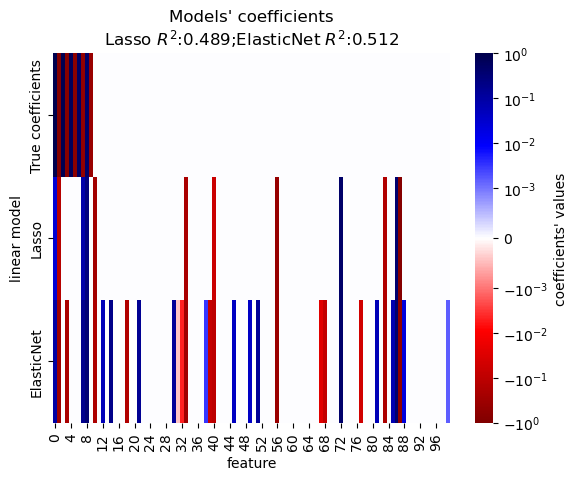

In [33]:
from matplotlib.colors import SymLogNorm
ax = sns.heatmap(
    df.T,
    # 增强可视化效果， 大小值区分更加明显
    norm=SymLogNorm(linthresh=10e-4, vmin=-1, vmax=1), 
    cbar_kws={"label": "coefficients' values"},
    cmap="seismic_r",
)
plt.xlabel('feature')
plt.ylabel("linear model")
plt.title(
    f"Models' coefficients\n"
    f"Lasso $R^2$:{r2_score_lasso:.3f};"
    f"ElasticNet $R^2$:{r2_score_enet:.3f}"
)


📊 对于高度相关的特征数据。
- ElasticNet 相比Lasso ，稀疏的更少，更加L2. 效果更好